In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def index_to_coordinate(index, extent, origin):
    """Return the pixel center of an index."""
    left, right, bottom, top = extent

    hshift = 0.5 * np.sign(right - left)
    left, right = left + hshift, right - hshift
    vshift = 0.5 * np.sign(top - bottom)
    bottom, top = bottom + vshift, top - vshift

    if origin == 'upper':
        bottom, top = top, bottom

    return {
        "[0, 0]": (left, bottom),
        "[M', 0]": (left, top),
        "[0, N']": (right, bottom),
        "[M', N']": (right, top),
    }[index]


def get_index_label_pos(index, extent, origin, inverted_xindex):
    """
    Return the desired position and horizontal alignment of an index label.
    """
    if extent is None:
        extent = lookup_extent(origin)
    left, right, bottom, top = extent
    x, y = index_to_coordinate(index, extent, origin)

    is_x0 = index[-2:] == "0]"
    halign = 'left' if is_x0 ^ inverted_xindex else 'right'
    hshift = 0.5 * np.sign(left - right)
    x += hshift * (1 if is_x0 else -1)
    return x, y, halign


def get_color(index, data, cmap):
    """Return the data color of an index."""
    val = {
        "[0, 0]": data[0, 0],
        "[0, N']": data[0, -1],
        "[M', 0]": data[-1, 0],
        "[M', N']": data[-1, -1],
    }[index]
    return cmap(val / data.max())


def lookup_extent(origin):
    """Return extent for label positioning when not given explicitly."""
    if origin == 'lower':
        return (-0.5, 6.5, -0.5, 5.5)
    else:
        return (-0.5, 6.5, 5.5, -0.5)


def set_extent_None_text(ax):
    ax.text(3, 2.5, 'equals\nextent=None', size='large',
            ha='center', va='center', color='w')


def plot_imshow_with_labels(ax, data, extent, origin, xlim, ylim):
    """Actually run ``imshow()`` and add extent and index labels."""
    im = ax.imshow(data, origin=origin, extent=extent)

    # extent labels (left, right, bottom, top)
    left, right, bottom, top = im.get_extent()
    if xlim is None or top > bottom:
        upper_string, lower_string = 'top', 'bottom'
    else:
        upper_string, lower_string = 'bottom', 'top'
    if ylim is None or left < right:
        port_string, starboard_string = 'left', 'right'
        inverted_xindex = False
    else:
        port_string, starboard_string = 'right', 'left'
        inverted_xindex = True
    bbox_kwargs = {'fc': 'w', 'alpha': .75, 'boxstyle': "round4"}
    ann_kwargs = {'xycoords': 'axes fraction',
                  'textcoords': 'offset points',
                  'bbox': bbox_kwargs}
    ax.annotate(upper_string, xy=(.5, 1), xytext=(0, -1),
                ha='center', va='top', **ann_kwargs)
    ax.annotate(lower_string, xy=(.5, 0), xytext=(0, 1),
                ha='center', va='bottom', **ann_kwargs)
    ax.annotate(port_string, xy=(0, .5), xytext=(1, 0),
                ha='left', va='center', rotation=90,
                **ann_kwargs)
    ax.annotate(starboard_string, xy=(1, .5), xytext=(-1, 0),
                ha='right', va='center', rotation=-90,
                **ann_kwargs)
    ax.set_title('origin: {origin}'.format(origin=origin))

    # index labels
    for index in ["[0, 0]", "[0, N']", "[M', 0]", "[M', N']"]:
        tx, ty, halign = get_index_label_pos(index, extent, origin,
                                             inverted_xindex)
        facecolor = get_color(index, data, im.get_cmap())
        ax.text(tx, ty, index, color='white', ha=halign, va='center',
                bbox={'boxstyle': 'square', 'facecolor': facecolor})
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)


def generate_imshow_demo_grid(extents, xlim=None, ylim=None):
    N = len(extents)
    fig = plt.figure(tight_layout=True)
    fig.set_size_inches(6, N * (11.25) / 5)
    gs = GridSpec(N, 5, figure=fig)

    columns = {'label': [fig.add_subplot(gs[j, 0]) for j in range(N)],
               'upper': [fig.add_subplot(gs[j, 1:3]) for j in range(N)],
               'lower': [fig.add_subplot(gs[j, 3:5]) for j in range(N)]}
    x, y = np.ogrid[0:6, 0:7]
    data = x + y

    for origin in ['upper', 'lower']:
        for ax, extent in zip(columns[origin], extents):
            plot_imshow_with_labels(ax, data, extent, origin, xlim, ylim)

    columns['label'][0].set_title('extent=')
    for ax, extent in zip(columns['label'], extents):
        if extent is None:
            text = 'None'
        else:
            left, right, bottom, top = extent
            text = (f'left: {left:0.1f}\nright: {right:0.1f}\n'
                    f'bottom: {bottom:0.1f}\ntop: {top:0.1f}\n')
        ax.text(1., .5, text, transform=ax.transAxes, ha='right', va='center')
        ax.axis('off')
    return columns



{'label': [<Axes: title={'center': 'extent='}>],
 'upper': [<Axes: title={'center': 'origin: upper'}>],
 'lower': [<Axes: title={'center': 'origin: lower'}>]}

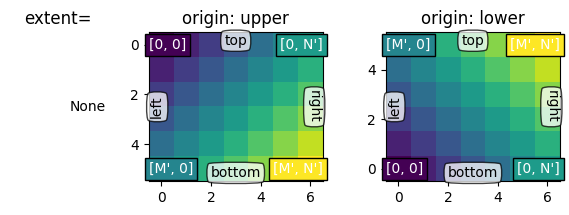

In [4]:
generate_imshow_demo_grid(extents=[None])

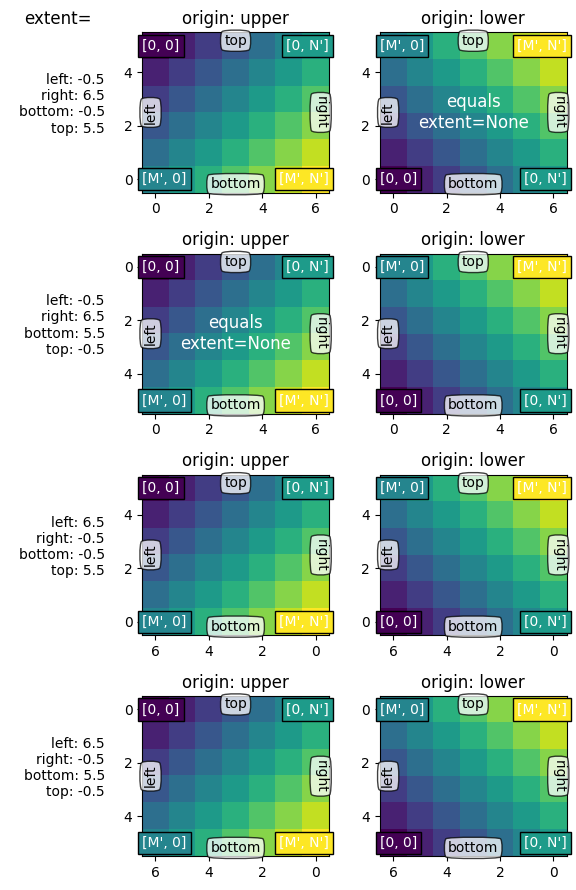

In [5]:
extents = [(-0.5, 6.5, -0.5, 5.5),
           (-0.5, 6.5, 5.5, -0.5),
           (6.5, -0.5, -0.5, 5.5),
           (6.5, -0.5, 5.5, -0.5)]

columns = generate_imshow_demo_grid(extents)
set_extent_None_text(columns['upper'][1])
set_extent_None_text(columns['lower'][0])


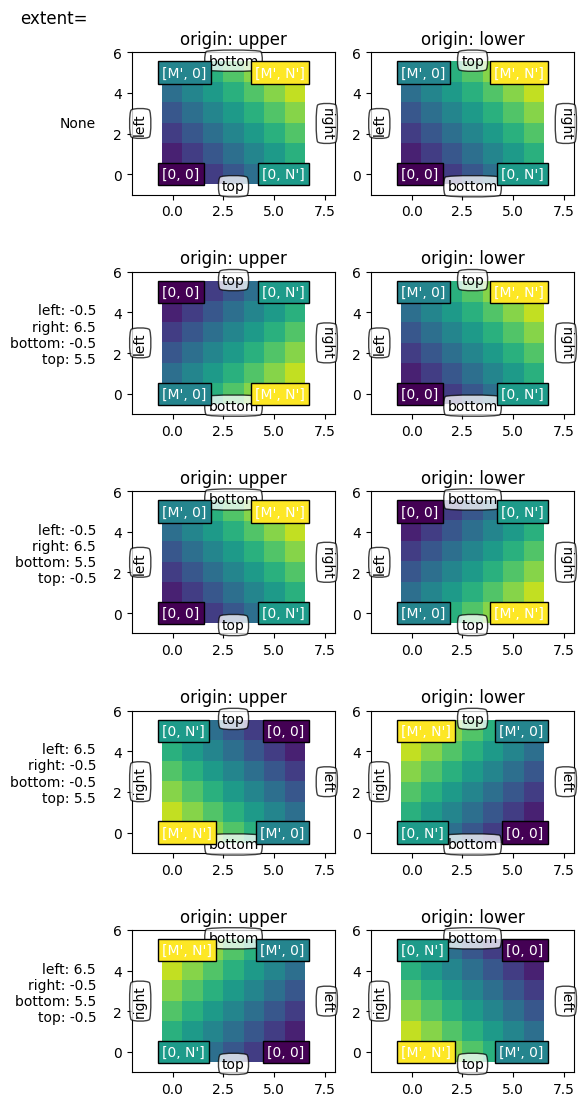

In [6]:
generate_imshow_demo_grid(extents=[None] + extents,
                          xlim=(-2, 8), ylim=(-1, 6))

plt.show()